<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/barcode_validator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sbooeshaghi/BMGP_2020

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 1004, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 1004 (delta 83), reused 5 (delta 1), pack-reused 817
Receiving objects: 100% (1004/1004), 491.51 MiB | 39.03 MiB/s, done.
Resolving deltas: 100% (407/407), done.
Checking out files: 100% (155/155), done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [63]:
fb_fn = "BMGP_2020/references/10xFB/kite/feature_barcodes.txt"

In [64]:
#@title Example barcodes
# MULTISEQ
bcs = [
  "GGAGAAGA",
  "CCACAATG",
  "CCAACCGG",
  "CGAAGCCC",
  "TCAGTCGA",
  "GACCAGCC",
  "CTCAAGGT",
  "CGCCGCAA",
  "ACCAGCCG",
]

bcs_names = [
"BC1",
"BC2",
"BC13",
"BC25",
"BC37",
"BC49",
"BC50",
"BC73",
"BC74",
]


# 10xCRISPR
bcs = [
       "GGCAACGCGACCCCACGAG",
       "ATGTCACCCCCAGACCCCG",
       "TGCAGCGCCGGCGACTCAC",
       "CGGGGCACCGGTGAGTCGC",
       "CACTCGGCGGACGCAAGGG",
       "GCGCACTCGGCGGACGCAA",
       "TGCTGCTTCGGCGACCGGG",
       "TTCTCGCGGGACACCGACG",
       "AGCCCAAGCCAGAGCGGCG",
       "GAGCGGCGCGGCCTGGAAG",
       "ACCCGAGCCGCACCCGCCG",
       "GCACGGGCGGCGGAGACTC",
       "AGCAGGGCTCTCCTCCCGG",
       "TGTGGCTGAAGCAGCGAGG",
       "GGAGAGGCGCAGCATCCAC",
       "GAGGCGCAGCATCCACAGG",
       "GAGCGAGGAGGGCGCTACG",
       "GTCGCTATCGGAGGCCGCG",
       "CACCAGATACAGCGCTCTG",
       "GCGGCAGCGCGGTCAGTGG",
       "GAGCCTCAGCGAGCGGAGG",
       "CTGGAGCCTCAGCGAGCGG",
       "GACGAAGTCTATAAAGGGC",
       "CATGGCGTGAGTACCGGGG",
       "TCCTCCTCAGCAGCACCGG",
       "GTCATGGAGCGGAACGCCA",
       "ACTTTGCTGTACCCATCAG",
       "AGGCCCAGTCATCCTACAC",
       "ATGTTGGCCGCCGCTGCGA",
       "GACGGGAGGATGGAGTCGA",
       "CTTCCACCACAGGTACCTA",
       "CCTCGCCTGGCTGCTCCCT",
       "CCGGCCGGGCGGCGAGTAG",
       "TGCTGATAAGGGAAGGGAC",
       "GCTGCTGCCACAGACCGAG",
       "CCCCGGGAGCGGAGAGCGA",
       "AAACGCACAGCAACTCGCA",
       "GGCGAAATGGCTCCGACCG",
       "CACAGGAGACCATGTCCGG",
       "AGGGCAGCGAGAGGTTCGC",
       "GAGCTTTCGCAGCTGGAGA",
       "TCACTATCTCCCGGGTGAA",
       "GGCCCGCGCGGCACTTACG",
       "GCGCGGGCGGGAAGCGAAG",
       "GCGCGGGCAGCGTGAAGCG",
       "GCGCGTGCGTACGCGACGG",
       "CGGACCTCGGGATCTGGGT",
       "CCGGGCGCTGTCGGACCTC",
       "CCTTGCACCGGGCTTTGCA",
       "CGCCGGCCGCGGTTCTCCC",
       "CCGGCCCAGGATGTAGAGC",
       "CTGCGGGCGCTGGCAAATC",
       "TGGTGTCATGGCAGCTGCG",
       "ACGCTTCGGGTTGGTGTCA",
       "GAGATCCGCGGAGGCCGAC",
       "CGACGGCAGAGGGGCCTAA",
       "CCGCCATGGCCGACAAGGA",
       "GTGCAGTCCCCGGTACTGA",
       "CCCAAGCGCCTACTCGCAC",
       "CTGCGAAAGCGCCAGGGTG",
       "GATCGCCGAGCGCGAGTGA",
       "GGGAGAGCGAGCAGCGAGC",
       "CTCAGGGCAGCGAGACTAT",
       "GCCGGCCGGCCGGCACGGG",
       "TTTTGGGCCGCGGCGGGAG",
       "GTCTCACCATGGAGCGGAA",
       "AGACGGAGCTCTTGAGTAG",
       "TGAGTAGAGGGCCGAAGAG",
       "CCGGCGGGTAGCTGGCGGG",
       "AGGCTCCGGCGGACCGAGG",
       "ACTTCGGTCGCGGGCGGTG",
       "GAAACGCTGCCGCTGAGGG",
       "GTTAGAGCCCGTGCGGAGG",
       "CTGCGGCGGAGCCTCCTTA",
       "TGCGTGAGGCGAGAGGAGC",
       "ACGCACGAGTGGAAGTCCC",
       "CGACACCGCGGCTTCCGCG",
       "GCCCGTCGGCGGGTGTCGA",
       "GCCCCGCTCGGCGATACCC",
       "GTCGCGTCCGACACCCGGT",
       "TACAGCAACAAGGCTGAGA",
       "GTCTTGGCCTGTTCCTCAA",
       "CGAGCCGGGACCCTGGTAC",
       "CTGGAGCGCGGCAGGTGAG",
       "GCCGGCGAACCAGGAAATA",
       "AGCGATAGCTGAGTGGCGG",
       "GCGCAGGCAGAAGTCACCG",
       "ACTCCACCGCCCGGAGCAG",
       "ACCGACTGACGGTAGGGAC",
       "GGACGGGAGGCGAGCAAGA",
]

bcs_names = [
"APH1A-1",
"APH1A-2",
"CDKN3-1",
"CDKN3-2",
"EZR-1",
"EZR-2",
"GRB2-1",
"GRB2-2",
"GSK3A-1",
"GSK3A-2",
"HRAS-1",
"HRAS-2",
"JUN-1",
"JUN-2",
"PPIB-1",
"PPIB-2",
"SNRNP70-1",
"SNRNP70-2",
"SNRNP40-1",
"SNRNP40-2",
"PPP2CA-1",
"PPP2CA-2",
"ATF4-1",
"ATF4-2",
"BAZ1B-1",
"BAZ1B-2",
"BRD4-1",
"BRD4-2",
"CAMLG-1",
"CAMLG-2",
"CSNK2A1-1",
"CSNK2A1-2",
"CTCF-1",
"CTCF-2",
"CTNNB1-1",
"CTNNB1-2",
"DHX9-1",
"DHX9-2",
"EIF4EBP1-1",
"EIF4EBP1-2",
"ELOF1-1",
"ELOF1-2",
"H2AFY-1",
"H2AFY-2",
"KDM1A-1",
"KDM1A-2",
"LMNA-1",
"LMNA-2",
"MBNL1-1",
"MBNL1-2",
"MORF4L1-1",
"MORF4L1-2",
"NOC2L-1",
"NOC2L-2",
"PAIP2-1",
"PAIP2-2",
"RBBP4-1",
"RBBP4-2",
"RBM25-1",
"RBM25-2",
"SET-1",
"SET-2",
"SMARCD1-1",
"SMARCD1-2",
"SRPK1-1",
"SRPK1-2",
"SRRT-1",
"SRRT-2",
"SUZ12-1",
"SUZ12-2",
"TPR-1",
"TPR-2",
"TRA2B-1",
"TRA2B-2",
"UBE2N-1",
"UBE2N-2",
"UBXN1-1",
"UBXN1-2",
"EZH2-1",
"EZH2-2",
"ACE2-1",
"ACE2-2",
"TMPRSS2-1",
"TMPRSS2-2",
"RAB1A-2",
"RAB1A-3",
"DPP4-1",
"DPP4-2",
"HDAC1-1",
"HDAC1-2",
]

In [65]:
def load_bcs(bcs_fn):
  bcs = []
  bcs_names = []
  with open(fb_fn, 'r') as f:
    for l in f.readlines():
      l = l.strip()
      bc, n = l.split("\t")
      bcs.append(bc)
      bcs_names.append(n)
  return (bcs, bcs_names)

# def check_kmers(bcs, bcs_names, k=None):
#   length = min([len(i) for i in bcs])
#   if not k:
#     k = length if length % 2 else length - 1
#     print(f"Optimal kmer length: {k}")

#   d = defaultdict(list)
#   for bc, bc_name in zip(bcs, bcs_names):
#     # forward strand
#     kmers = kmerize(bc, k)
#     for kmer in kmers:
#       d["".join(kmer)].append(bc_name)
    
#     # reverse complement strand
#     kmers = kmerize(rev_c(bc), k)
#     for kmer in kmers:
#       d["".join(kmer)].append(bc_name + "_rc")
#   return d



def merge_ecs(ecs1, ecs2):
  m = defaultdict(set)

  uniq = set(list(ecs1.keys()) + list(ecs2.keys()))
  print(f"{len(uniq):,.0f} unique kmers")
  for k in uniq:
    m[k].update(ecs2[k])
    m[k].update(ecs1[k])
  return m



In [66]:
bcs, bcs_names = load_bcs(fb_fn)

# Validation

## Length validation

In [67]:
def qcbc_complexity(min_bc_len):
  max_bcs = 4**min_bc_len
  return max_bcs

In [68]:
bc_len = min([len(i) for i in bcs])
print(f"{qcbc_complexity(bc_len):,.0f}")
# how many if you impose a hamming distance constrain?

1,073,741,824


In [69]:
# return to later
from scipy.special import comb
# from here https://www.johndcook.com/blog/2020/02/24/hamming-codes/

q = 4  # alphabet size
n = 10 # barcode length
d = 5  # min hamming distance
t = (d-1)//2
denom = sum([comb(n, k)*(q-1)**k for k in range(0, t)])

In [70]:
int(q**n/denom) # this is an upper bound, 

33825

## Barcodes with subsequences that are ambiguous

In [71]:
def kmerize(s, k):
  L = len(s)
  return [s[i:i+k] for i in range(L-k+1)]
kmerize("sina" ,3)

['sin', 'ina']

In [72]:
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
def rev_c(seq):
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases
rev_c("ATC")

'GAT'

In [73]:
def make_ec(bcs, bcs_names, k=None, rc=False):
  length = min([len(i) for i in bcs])
  if not k:
    k = length
  d = defaultdict(list)
  for bc, bc_name in zip(bcs, bcs_names):
    # forward strand
    if rc:
      bc = rev_c(bc)
      bc_name = f"{bc_name}_rc"
    kmers = kmerize(bc, k)
    for kmer in kmers:
      d[''.join(kmer)].append(bc_name)
  return d


def make_rev_ec(ec):
  rev_ec = {}
  for k,v in ec.items():
    for n in v:
      rev_ec[n] = k

  return rev_ec

In [74]:
def ambig_ecs(ecs):
  ambig = defaultdict(list)
  for k, v in ecs.items():
    if len(v) > 1:
      ambig[k] = v
  return ambig

In [75]:
ecs = make_ec(bcs, bcs_names, k=9, rc=False)

def qcbc_ambiguous(*list_ecs): # why 9?
  ambig_bcs = []
  for ecs in list_ecs:
    # find the ambiguous barcodes 
    ambig = ambig_ecs(ecs)

    # append the ambig barcodes to abmig_bcs
    ambig_bcs.append(ambig)
  return ambig_bcs

# given a set of ecs, this returns those that are ambiguous (len > 1)
qcbc_ambiguous(make_ec(bcs, bcs_names, 8), make_ec(bcs, bcs_names, 9))

[defaultdict(list, {}), defaultdict(list, {})]

## Shared subsequence

In [76]:
def ham(k1, k2):
    if len(k1)!=len(k2):
      raise "kmers not the same length"
    first  = np.array(list(k1))
    second = np.array(list(k2))
    dist = (first!=second).sum()
    return dist

def cmp_kmers(ecs, rc = False):
  kmers = list(ecs.keys())
  ecs = list(ecs.values())
  d = defaultdict()
  n = len(kmers)
  nc = n*(n-1)//2
  checkpoint = nc//10
  print(f"Making {nc:,.0f} comparisons")
  c = 0
  for i in range(n):
    for j in range(i+1, n):
      c += 1
      if c % checkpoint == 0:
        print(f"{c:,.0f}")
      k1, k2 = kmers[i], kmers[j]
      
      # if comparing kmer to revc of other kmers
      if rc:
        k2 = rev_c(k2)
      
      dist = ham(k1, k2)
      d[(kmers[i], kmers[j])] = dist
  return d

In [77]:
# m = merge_ecs(ecs, ecs_rc)
# c = cmp_kmers(m)


In [78]:
# gets the hamming distance between all pairwise kmers in the ec
def qcbc_kmer_ham(ecs):
  c = cmp_kmers(ecs)
  return c
# return the label from which the barcode arises
c = qcbc_kmer_ham(ecs)
# kmer1, kmer2, hamming distance <-- maybe in a future version
# ec_index 1, kmer1, ec_index 2, kmer2, hamming distance <-- maybe in a future version

Making 24,976 comparisons
2,497
4,994
7,491
9,988
12,485
14,982
17,479
19,976
22,473
24,970


In [79]:
df = pd.Series(c)

In [80]:
df.nsmallest(10)

AGTTCACTC  AGTTCAGTC    1
TTGTCCTGT  TTGTCCTAT    1
CGCCGCATT  CGCCGTATT    1
GTTGTCCTA  GTTGTCCGA    1
TCATTGTAA  TCTTTGTCA    2
GTTCCCGCT  GTTCACTCT    2
CTCAGACCT  CTCCTACCT    2
ACCTCCGTA  AGCGCCGTA    2
AGTACCTAG  GGTCCCTAG    2
GTACCTAGT  GTCCCTAGA    2
dtype: int64

In [81]:
[(i, ecs[i],j, ecs[j], df[i,j]) for i,j in df.nsmallest(10).index]

[('AGTTCACTC', ['CD16'], 'AGTTCAGTC', ['CD197'], 1),
 ('TTGTCCTGT', ['CD25'], 'TTGTCCTAT', ['CD127'], 1),
 ('CGCCGCATT', ['CD56'], 'CGCCGTATT', ['PD-1'], 1),
 ('GTTGTCCTA', ['CD127'], 'GTTGTCCGA', ['CD274'], 1),
 ('TCATTGTAA', ['CD3'], 'TCTTTGTCA', ['CD86'], 2),
 ('GTTCCCGCT', ['CD4'], 'GTTCACTCT', ['CD16'], 2),
 ('CTCAGACCT', ['CD14'], 'CTCCTACCT', ['IgG2a'], 2),
 ('ACCTCCGTA', ['CD14'], 'AGCGCCGTA', ['PD-1'], 2),
 ('AGTACCTAG', ['CD15'], 'GGTCCCTAG', ['CD20'], 2),
 ('GTACCTAGT', ['CD15'], 'GTCCCTAGA', ['CD20'], 2)]

### Varying length of subesequnce

In [82]:
# how does barcode ambiguity vary with ec length?
x  = np.arange(2,10)
ambig_bcs = qcbc_ambiguous(*[make_ec(bcs, bcs_names, i) for i in x])

def list_ambiguous(ambig_bcs):
  a = set()
  abcs = []
  for i in ambig_bcs:
    for k,v in i.items():
      a.update(v)
    abcs.append(a)
    a = set()
  return abcs
  


### Pairwise hamming

In [83]:
def qcbc_pwham(bcs, rc=False):
  n_bcs = len(bcs)
  mat = np.zeros(( n_bcs, n_bcs ))
  mat_rc = np.zeros(( n_bcs, n_bcs ))
  for i in range(len(bcs)):
    for j in range(i, len(bcs)):
      first  = np.array(list(bcs[i]))
      second = np.array(list(bcs[j]))
      second_rc = np.array(list(rev_c(bcs[j])))
      mat[i,j] = (first!=second).sum()
      mat_rc[i,j] = (first!=second_rc).sum()
  if rc:
    return mat_rc[np.triu_indices(mat_rc.shape[0], k=1)]
  return mat[np.triu_indices(mat.shape[0], k=1)]

# All together

In [84]:
x  = np.arange(2,10)

In [96]:
bc_len = min([len(i) for i in bcs])
print(f"{qcbc_complexity(bc_len):,.0f}")

x  = np.arange(2,len(bcs[0]))
ambig_bcs = qcbc_ambiguous(*[make_ec(bcs, bcs_names, i) for i in x])
nbc = np.array([len(i) for i in list_ambiguous(ambig_bcs)])

blah = qcbc_pwham(bcs)
blah2 = qcbc_pwham(bcs, True)

1,073,741,824


In [86]:
ambig_bcs[-1]

defaultdict(list, {})

# Plotting

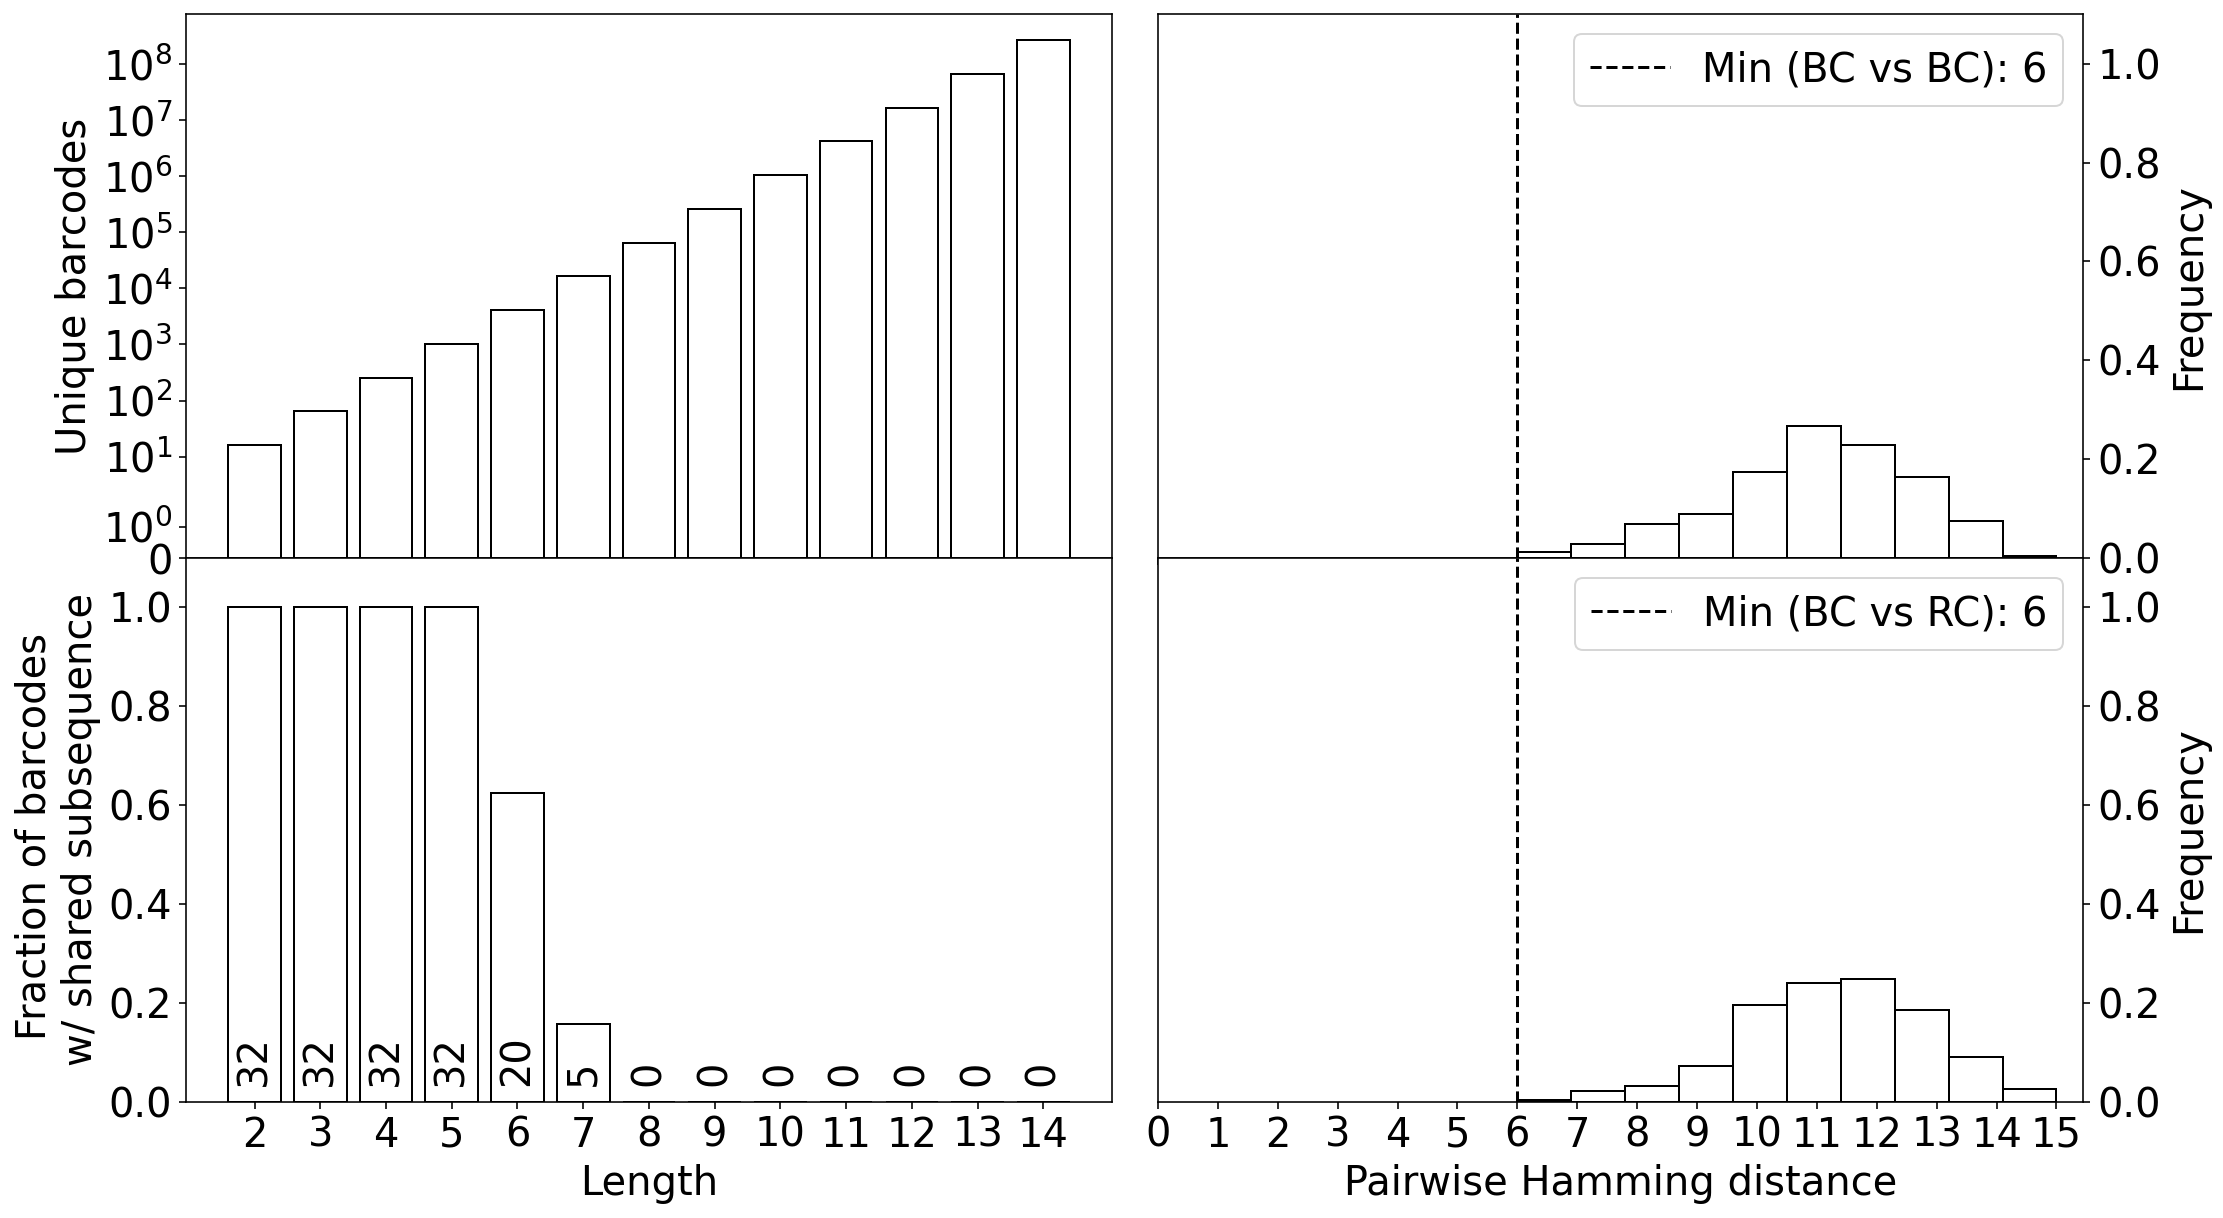

In [104]:
fig, axs = plt.subplots(figsize=(17,10), ncols=2, nrows=2)
fig.subplots_adjust(hspace=0, wspace=0.05)

## Barcode diversity
ax = axs[0,0]
x  = np.arange(2,len(bcs[0]))
y = 4**x

ax.bar(x, y, edgecolor="k", color="white")
ax.set(**{
    "yscale": "symlog",
    "xticks": x,
    "xlabel": "Barcode length",
    "ylabel": "Unique barcodes"
})


#############################################
# Shared subseq
ax = axs[1, 0]
nbc = np.array([len(i) for i in list_ambiguous(ambig_bcs)])
y = nbc / len(bcs)

for idx, (xx, yy) in enumerate(zip(x,y)):
  ax.text(xx, 0.05, f"{nbc[idx]:,.0f}", ha="center", rotation=90)

ax.bar(x, y, edgecolor="k", color="white")
ax.set(**{
    "ylim": (0, 1.1),
    "xticks": x,
    "xlabel": "Length",
    "ylabel": "Fraction of barcodes \nw/ shared subsequence",
})

#############################################
## Pairwise hamming
ax = axs[0,1]
x = blah
ax.hist(x, density=True, edgecolor="k", color="white")
mn = min(x)
ax.axvline(mn, label=f"Min (BC vs BC): {mn:,.0f}", color="k", linestyle="--")
ax.set(**{
    "xlabel": "Hamming distance",
    "ylabel": "Frequency",
    "ylim": (0,1.1),
    "xticks": np.arange(0, int(max(x))+1),
    "xticklabels": []
})
ax.legend()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

########################################
ax = axs[1,1]
x = blah2
ax.hist(x, density=True, edgecolor="k", color="white")
mn = min(x)
ax.axvline(mn, label=f"Min (BC vs RC): {mn:,.0f}", color="k", linestyle="--")

ax.set(**{
    "xlabel": "Pairwise Hamming distance",
    "ylabel": "Frequency",
    "ylim": (0,1.1),
    "xticks": np.arange(0, int(max(x))+1),
    "xticklabels": np.arange(0, int(max(x))+1),
})
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


ax.legend()

fig.show()